In [1]:
# Core
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

# Machine learning
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
from datetime import datetime

# MSE imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts
from asteroid_model import make_model_ast_pos
from nearest_asteroid import nearest_ast_elt_cart, calc_elt_pos, ts
from nearest_asteroid import nearest_ast_elt_cov, elt_q_norm, plot_elt_transform_pdf, plot_elt_transform_map
from nearest_asteroid import ast_elt_transform, elts_to_X_cov, calc_beta, make_interp_x
from astro_utils import datetime_to_mjd

In [2]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [3]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [4]:
# Review orbital elements of known asteroids
ast_elt

,Num,Name,epoch,a,e,inc,Omega,omega,M,H,G,Ref,f,P,n,long,theta,pomega,T_peri,row_num
Num,,,,,,,,,,,,,,,,,,,,
1,1,Ceres,58600.0,2.769165,0.076009,0.184901,1.401596,1.284522,1.350398,3.34,0.12,JPL 46,1.501306,1683.145749,0.003733,4.036516,4.187424,2.686118,-361.745873,0
2,2,Pallas,58600.0,2.772466,0.230337,0.608007,3.020817,5.411373,1.041946,4.13,0.11,JPL 35,1.490912,1686.155979,0.003726,3.190951,3.639917,2.149005,-279.616804,1
3,3,Juno,58600.0,2.669150,0.256942,0.226699,2.964490,4.330836,0.609557,5.33,0.32,JPL 108,0.996719,1592.787270,0.003945,1.621697,2.008860,1.012141,-154.522558,2
4,4,Vesta,58600.0,2.361418,0.088721,0.124647,1.811840,2.630709,1.673106,3.20,0.32,JPL 34,-4.436417,1325.432768,0.004740,6.115656,0.006132,4.442550,-352.940421,3
5,5,Astraea,58600.0,2.574249,0.191095,0.093672,2.470978,6.260280,4.928221,6.85,0.15,JPL 108,-1.738676,1508.600442,0.004165,1.093108,0.709396,2.448072,325.328481,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255499,1255499,2019 QG,58600.0,0.822197,0.237862,0.220677,5.066979,3.770460,0.503214,21.55,0.15,JPL 1,0.807024,272.309165,0.023074,-3.225717,-2.921908,-3.728932,-21.808984,733484
1255501,1255501,2019 QL,58600.0,2.722045,0.530676,0.113833,4.741919,2.351059,5.297173,19.21,0.15,JPL 1,-2.082964,1640.368337,0.003830,-0.176219,-1.273172,0.809793,257.420824,733485
1255502,1255502,2019 QQ,58600.0,1.053137,0.389091,0.172121,5.648270,2.028352,3.266522,25.31,0.15,JPL 1,-3.081905,394.753268,0.015917,-1.623227,-1.688469,1.393436,189.527723,733486


## Search for Asteroid with Nearest Elements Based on Orbital Trajectories

In [5]:
# First 64 odd numbered asteroids
batch_size = 64
ast_nums = np.arange(1,2*batch_size,2, dtype=np.int32)

# Candidate elements from these asteroids_
elts_ast = asteroid_elts(ast_nums)

In [6]:
# Manually change element_id to disambiguate concepts of element_id and asteroid_num
elts_ast.element_id = np.arange(batch_size)

In [7]:
# Review candidate elements
elts_ast

,element_id,a,e,inc,Omega,omega,f,epoch
0,0,2.769165,0.076009,0.184901,1.401596,1.284522,1.501306,58600.0
1,1,2.669150,0.256942,0.226699,2.964490,4.330836,0.996719,58600.0
2,2,2.574249,0.191095,0.093672,2.470978,6.260280,-1.738676,58600.0
3,3,2.385334,0.231206,0.096406,4.530233,2.535354,-3.593901,58600.0
4,4,2.385637,0.123114,0.097334,1.202682,0.112004,-1.697553,58600.0
...,...,...,...,...,...,...,...,...
59,59,2.581258,0.080455,0.100988,3.554433,2.990562,-0.184508,58600.0
60,60,3.451839,0.131877,0.132604,1.276228,5.200234,3.674133,58600.0
61,61,2.694898,0.120490,0.111943,5.370912,2.195213,-0.875056,58600.0
62,62,2.744362,0.077776,0.081391,2.949472,1.916123,-3.376722,58600.0


In [8]:
# Search for near elements on unperturbed asteroids
elts_ast_near_cart = nearest_ast_elt_cart(elts_ast)

In [9]:
# Review nearest asteroid to these elements
elts_ast_near_cart

,element_id,nearest_ast_num,nearest_ast_name,nearest_ast_dist,a,e,inc,Omega,omega,f,epoch
0,0,1,Ceres,0.0,2.769165,0.076009,0.184901,1.401596,1.284522,1.501306,58600.0
1,1,3,Juno,0.0,2.669150,0.256942,0.226699,2.964490,4.330836,0.996719,58600.0
2,2,5,Astraea,0.0,2.574249,0.191095,0.093672,2.470978,6.260280,-1.738676,58600.0
3,3,7,Iris,0.0,2.385334,0.231206,0.096406,4.530233,2.535354,-3.593901,58600.0
4,4,9,Metis,0.0,2.385637,0.123114,0.097334,1.202682,0.112004,-1.697553,58600.0
...,...,...,...,...,...,...,...,...,...,...,...
59,59,119,Althaea,0.0,2.581258,0.080455,0.100988,3.554433,2.990562,-0.184508,58600.0
60,60,121,Hermione,0.0,3.451839,0.131877,0.132604,1.276228,5.200234,3.674133,58600.0
61,61,123,Brunhild,0.0,2.694898,0.120490,0.111943,5.370912,2.195213,-0.875056,58600.0
62,62,125,Liberatrix,0.0,2.744362,0.077776,0.081391,2.949472,1.916123,-3.376722,58600.0


In [10]:
# Review elts_ast, now with nearest asteroid information added
elts_ast

,element_id,a,e,inc,Omega,omega,f,epoch,nearest_ast_num,nearest_ast_dist
0,0,2.769165,0.076009,0.184901,1.401596,1.284522,1.501306,58600.0,1,0.0
1,1,2.669150,0.256942,0.226699,2.964490,4.330836,0.996719,58600.0,3,0.0
2,2,2.574249,0.191095,0.093672,2.470978,6.260280,-1.738676,58600.0,5,0.0
3,3,2.385334,0.231206,0.096406,4.530233,2.535354,-3.593901,58600.0,7,0.0
4,4,2.385637,0.123114,0.097334,1.202682,0.112004,-1.697553,58600.0,9,0.0
...,...,...,...,...,...,...,...,...,...,...
59,59,2.581258,0.080455,0.100988,3.554433,2.990562,-0.184508,58600.0,119,0.0
60,60,3.451839,0.131877,0.132604,1.276228,5.200234,3.674133,58600.0,121,0.0
61,61,2.694898,0.120490,0.111943,5.370912,2.195213,-0.875056,58600.0,123,0.0
62,62,2.744362,0.077776,0.081391,2.949472,1.916123,-3.376722,58600.0,125,0.0


## Search Around Perturbed Elements

In [11]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [12]:
# Review perturbed elements
elts_pert

,element_id,a,e,inc,Omega,omega,f,epoch,nearest_ast_num,nearest_ast_dist
0,0,2.838801,0.076629,0.185336,1.423708,1.286215,1.505043,58600.0,1,0.0
1,1,2.650761,0.260451,0.224503,2.952139,4.341224,0.974977,58600.0,3,0.0
2,2,2.658979,0.190957,0.086906,2.478724,6.245999,-1.735653,58600.0,5,0.0
3,3,2.574076,0.233538,0.096705,4.543753,2.571874,-3.587175,58600.0,7,0.0
4,4,2.357869,0.123560,0.092699,1.186504,0.094446,-1.712979,58600.0,9,0.0
...,...,...,...,...,...,...,...,...,...,...
59,59,2.710286,0.079335,0.100670,3.554800,2.976454,-0.168489,58600.0,119,0.0
60,60,3.370120,0.132654,0.128909,1.288130,5.185578,3.711172,58600.0,121,0.0
61,61,2.669997,0.123158,0.105333,5.365497,2.184752,-0.857036,58600.0,123,0.0
62,62,2.596675,0.077010,0.079443,2.955129,1.879054,-3.403240,58600.0,125,0.0


In [13]:
# Search for near elements on unperturbed asteroids
elts_pert_near_cart = nearest_ast_elt_cart(elts_pert)

In [14]:
# Review elts_pert, now with nearest asteroid information added
elts_pert

,element_id,a,e,inc,Omega,omega,f,epoch,nearest_ast_num,nearest_ast_dist
0,0,2.838801,0.076629,0.185336,1.423708,1.286215,1.505043,58600.0,1141687,0.002623
1,1,2.650761,0.260451,0.224503,2.952139,4.341224,0.974977,58600.0,3,0.004228
2,2,2.658979,0.190957,0.086906,2.478724,6.245999,-1.735653,58600.0,417755,0.003576
3,3,2.574076,0.233538,0.096705,4.543753,2.571874,-3.587175,58600.0,529459,0.003443
4,4,2.357869,0.123560,0.092699,1.186504,0.094446,-1.712979,58600.0,234585,0.002984
...,...,...,...,...,...,...,...,...,...,...
59,59,2.710286,0.079335,0.100670,3.554800,2.976454,-0.168489,58600.0,1156228,0.003300
60,60,3.370120,0.132654,0.128909,1.288130,5.185578,3.711172,58600.0,1149232,0.009668
61,61,2.669997,0.123158,0.105333,5.365497,2.184752,-0.857036,58600.0,1205775,0.003321
62,62,2.596675,0.077010,0.079443,2.955129,1.879054,-3.403240,58600.0,418270,0.003645


In [15]:
np.mean(elts_pert.nearest_ast_dist)

0.004451572895050049

## Build and Plot Transformed Orbital Elements

In [16]:
# Set number of sample points
N_samp_u: int = 2**16
z_range: float = 6.0
N_samp_z: int = int(200*z_range + 1)

# Sample CDF levels: N_samp evenly spaced
cdf_samp_u = (np.arange(N_samp_u) + 0.5) / N_samp_u

# Sample CDF levels: z_samp points evenly spaced by Z
z_samp = np.linspace(-z_range, z_range, N_samp_z)
cdf_samp_z = norm.cdf(z_samp)
pdf_samp_z = norm.pdf(z_samp)

# Combine the two sets of sample points
cdf_samp = np.unique(np.hstack([cdf_samp_u, cdf_samp_z]))

In [17]:
# Build transformed elements and interpolators
ast_elt_xf, interp_tbl = ast_elt_transform(ast_elt)

In [18]:
# Review orbital elements with extra transformed columns
ast_elt_xf

,Num,Name,a,e,inc,Omega,omega,f,epoch,log_a,...,cos_f,log_a_z,e_z,sin_inc_z,sin_Omega_z,cos_Omega_z,sin_omega_z,cos_omega_z,sin_f_z,cos_f_z
Num,,,,,,,,,,,,,,,,,,,,,
1,1,Ceres,2.769165,0.076009,0.184901,1.401596,1.284522,1.501306,58600.0,1.018546,...,0.069434,0.145243,-0.868136,0.312430,1.608535,0.135414,1.333860,0.230436,2.011804,0.055472
2,2,Pallas,2.772466,0.230337,0.608007,3.020817,5.411373,1.490912,58600.0,1.019737,...,0.079800,0.150151,0.867551,3.948513,0.096513,-1.769034,-0.763799,0.590263,1.952677,0.063781
3,3,Juno,2.669150,0.256942,0.226699,2.964490,4.330836,0.996719,58600.0,0.981760,...,0.543060,-0.006347,1.166776,0.696451,0.141780,-1.585966,-1.167759,-0.309298,0.904990,0.475357
4,4,Vesta,2.361418,0.088721,0.124647,1.811840,2.630709,-4.436417,58600.0,0.859262,...,-0.272482,-0.511140,-0.725163,-0.246285,1.427433,-0.193528,0.419620,-0.983751,1.354143,-0.222005
5,5,Astraea,2.574249,0.191095,0.093672,2.470978,6.260280,-1.738676,58600.0,0.945558,...,-0.167092,-0.155530,0.426202,-0.535290,0.563529,-0.794462,-0.018278,2.442548,-1.612398,-0.134353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255499,1255499,2019 QG,0.822197,0.237862,0.220677,5.066979,3.770460,0.807024,58600.0,-0.195775,...,0.691651,-4.858783,0.952183,0.641331,-1.211409,0.286804,-0.524904,-0.840998,0.696311,0.652981
1255501,1255501,2019 QL,2.722045,0.530676,0.113833,4.741919,2.351059,-2.082964,58600.0,1.001383,...,-0.490068,0.074519,4.245392,-0.347074,-2.349491,0.023562,0.679640,-0.669356,-0.982089,-0.420742
1255502,1255502,2019 QQ,1.053137,0.389091,0.172121,5.648270,2.028352,-3.081905,58600.0,0.051773,...,-0.998219,-3.838674,2.653026,0.194372,-0.530450,0.834141,1.055295,-0.373589,-0.047643,-2.074874


## Semimajor Axis, a

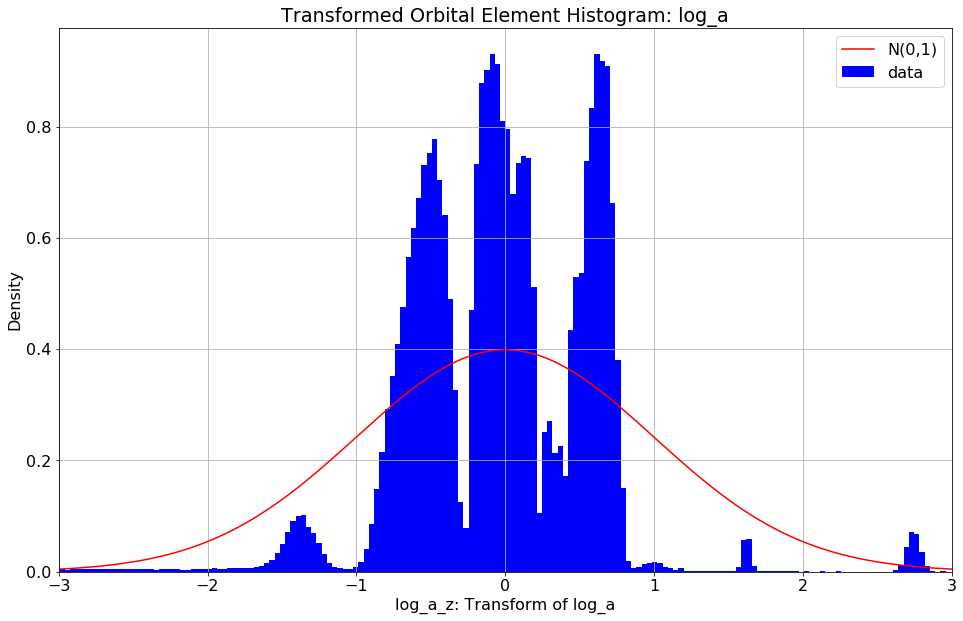

In [19]:
# Plot PDF of a
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='log_a')

In [21]:
fig.savefig('../figs/elts_cov/log_a_z.png', bbox_inches='tight')

In [28]:
# # Plot transform of a
# fig, ax = plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='log_a')

## Eccentricity, e

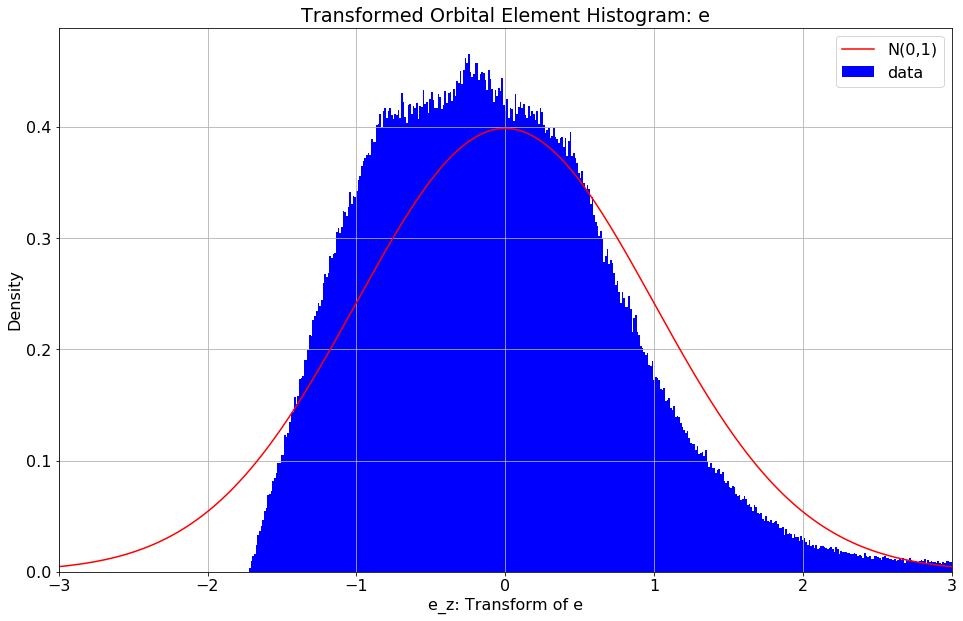

In [24]:
# Plot PDF of e
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='e')

In [25]:
fig.savefig('../figs/elts_cov/e_z.png', bbox_inches='tight')

In [27]:
# # Plot transform of e
# fig, ax = plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='e')

## Inclination, inc

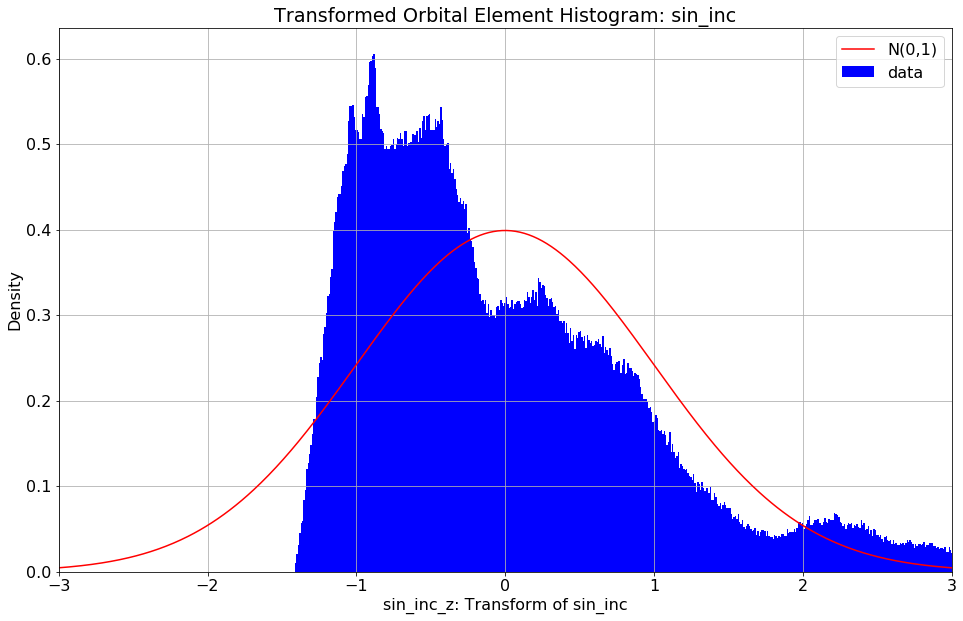

In [31]:
# Plot PDF of sin_inc
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='sin_inc')

In [32]:
fig.savefig('../figs/elts_cov/sin_inc_z.png', bbox_inches='tight')

In [30]:
# # Plot transform of sin_inc
# fig, ax plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='sin_inc')

## Omega

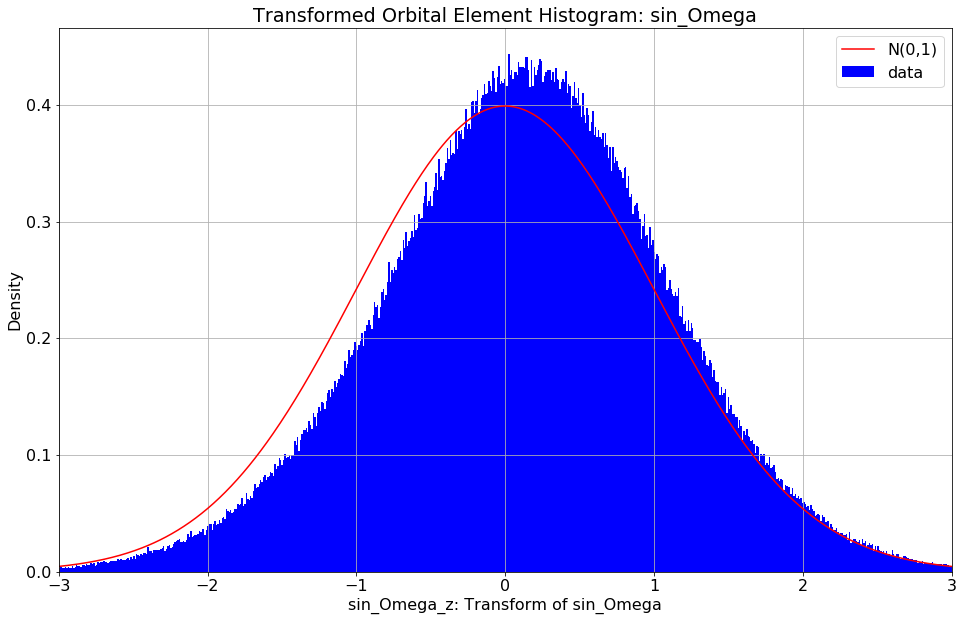

In [41]:
# Plot PDF of sin_Omega
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='sin_Omega')

In [42]:
fig.savefig('../figs/elts_cov/sin_Omega_z.png', bbox_inches='tight')

In [34]:
# # Plot PDF of sin_Omega
# fig, ax = plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='sin_Omega')

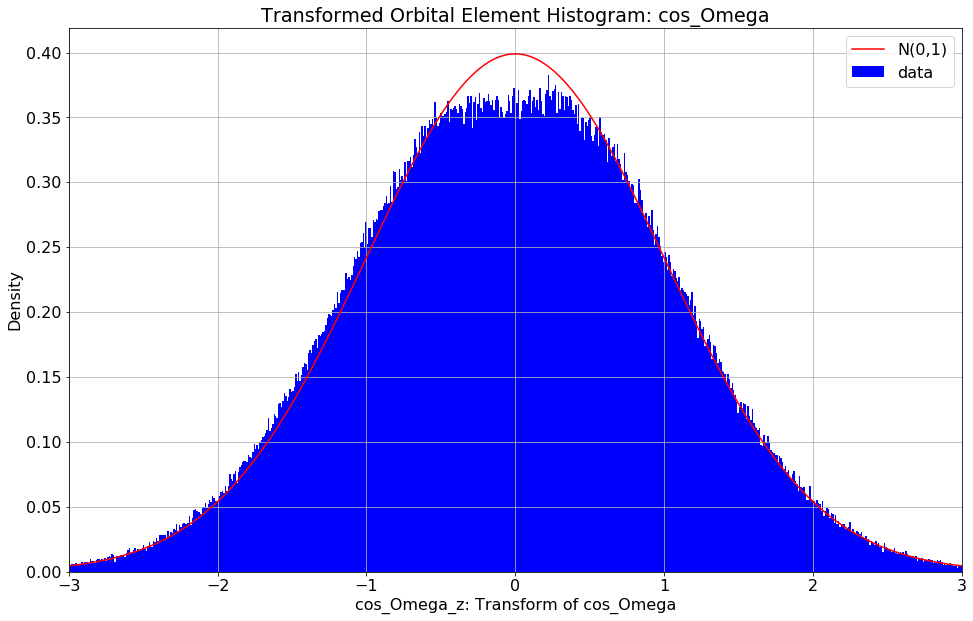

In [35]:
# Plot PDF of cos_Omega
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='cos_Omega')

In [ ]:
# Plot map of cos_Omega
# plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='cos_Omega')

## omega

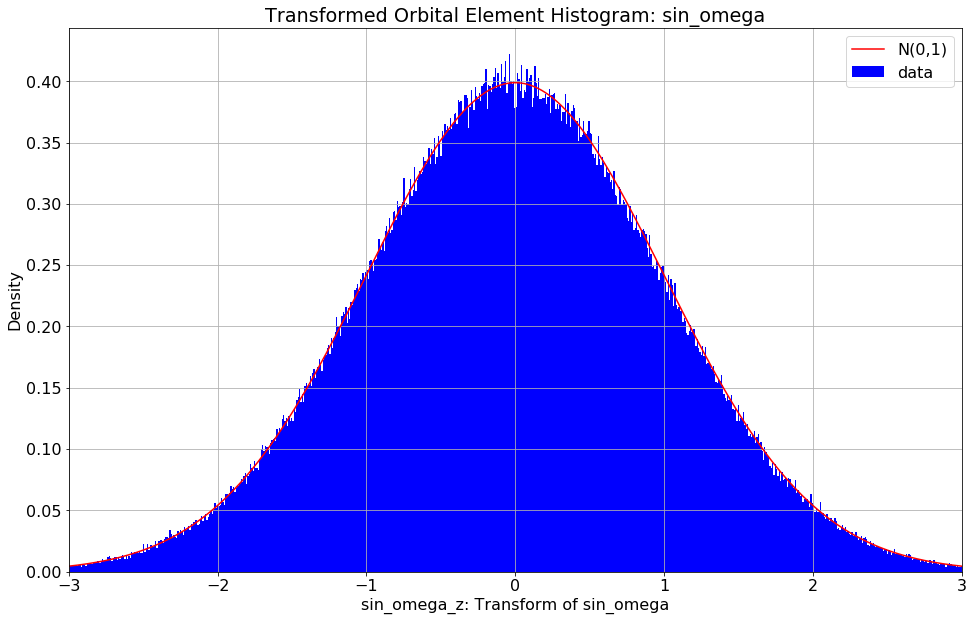

In [36]:
# Plot PDF of sin_omega
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='sin_omega')

In [ ]:
# # Plot map of sin_omega
# plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='sin_omega')

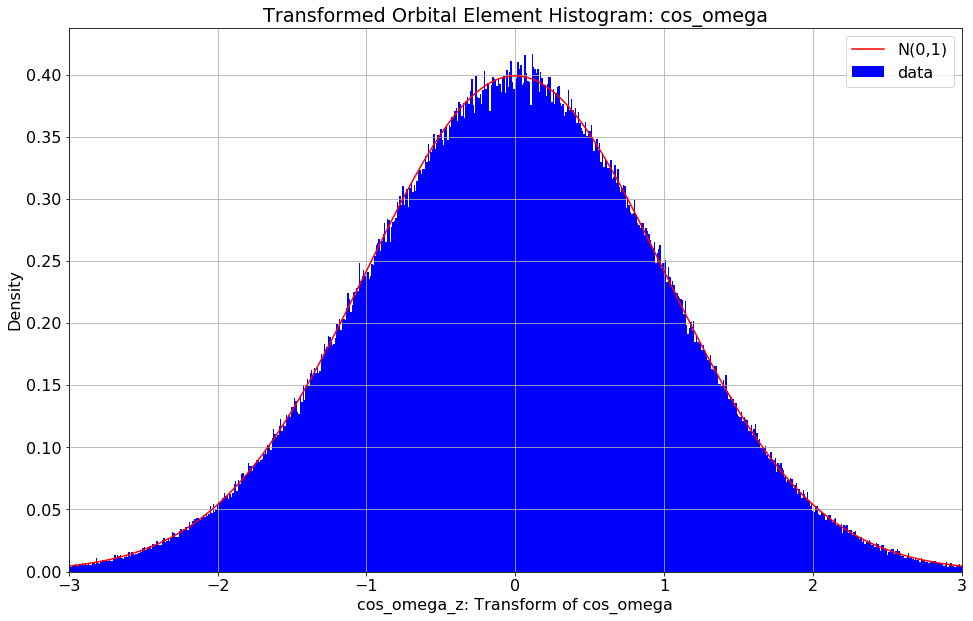

In [38]:
# Plot PDF of cos_omega
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='cos_omega')

In [ ]:
# # Plot PDF of sin_Omega
# plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='cos_omega')

## True Anomaly, f

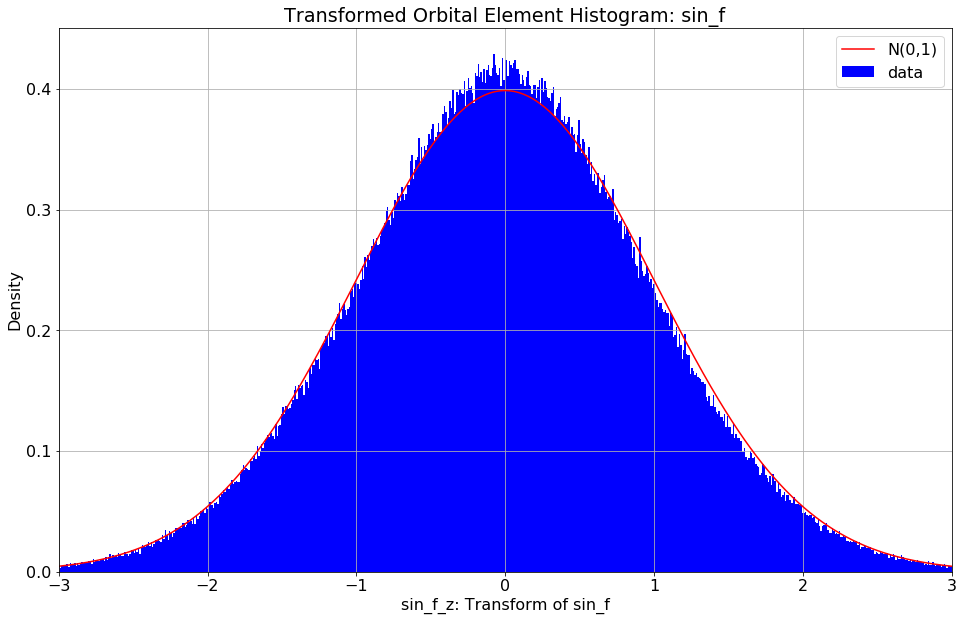

In [40]:
# Plot PDF of sin_f
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='sin_f')

In [43]:
# Plot map of sin_omega
# plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='sin_f')

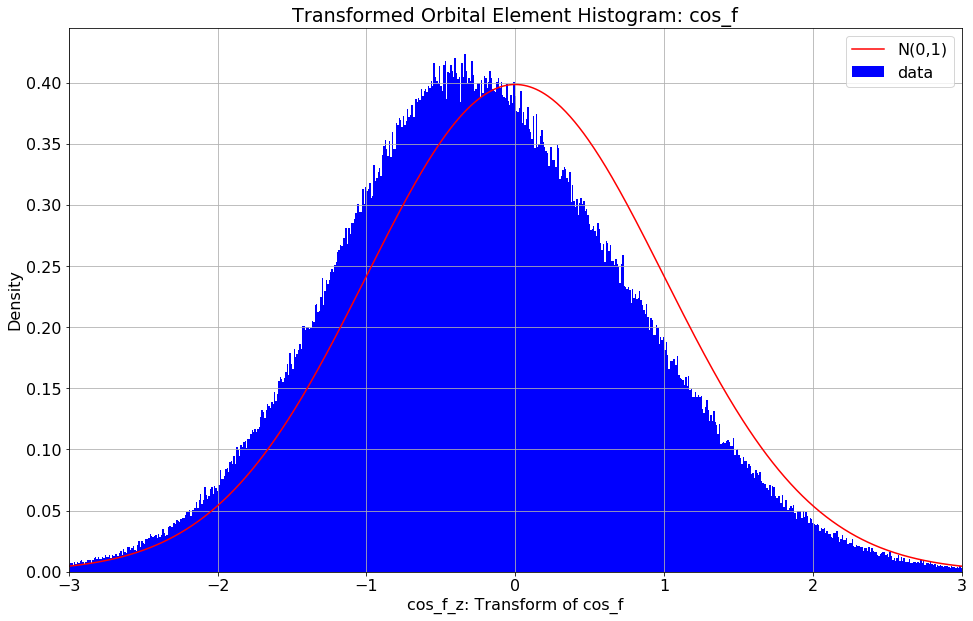

In [46]:
# Plot PDF of cos_f
fig, ax = plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='cos_f')

In [45]:
# Plot map of cos_f
# plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='cos_f')

## Covariance of Transformed Elements

In [47]:
# Build tranformation matrix beta and X_beta for computing distance to orbital elements
beta, X_beta = calc_beta(ast_elt)

In [48]:
# Assemble covaraiance matrix
Q = np.cov(X_beta, rowvar=False)

In [49]:
np.round(Q, 2)

array([[ 1., -0., -0.,  0.,  0., -0., -0., -0.,  0.],
       [-0.,  1.,  0.,  0.,  0., -0., -0., -0.,  0.],
       [-0.,  0.,  1., -0., -0., -0.,  0.,  0., -0.],
       [ 0.,  0., -0.,  1.,  0., -0., -0., -0.,  0.],
       [ 0.,  0., -0.,  0.,  1.,  0., -0., -0.,  0.],
       [-0., -0., -0., -0.,  0.,  1.,  0.,  0., -0.],
       [-0., -0.,  0., -0., -0.,  0.,  1., -0.,  0.],
       [-0., -0.,  0., -0., -0.,  0., -0.,  1.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  1.]])

In [ ]:
# Demonstrate that Q is the 9x9 identity matrix
Q_err = np.linalg.norm(Q - np.identity(9))
print(f'Error of matrix Q vs. identity: {Q_err:6.2e}')

## Search for Asteroid with Nearest Orbital Elements Based on Covariance of Transformed Elements

In [ ]:
# Search for near elements on perturbed asteroids
ast_elt_near_pert_cov = nearest_ast_elt_cov(elts_pert)

In [ ]:
# Use q_norm method to compute Q_norm from nearest Cartesian asteroid
q_norm = elt_q_norm(elts=elts_pert, ast_num=elts_pert.nearest_ast_num.values)

# Add this to elts_pert as well
elts_pert.insert(loc=9, column='q_norm', value=q_norm)

In [ ]:
# Review elts_port; now has nearest_ast_num_cov and nearest_ast_Q_norm as well
elts_pert

In [ ]:
np.mean(elts_pert.q_norm)

In [ ]:
np.mean(elts_pert.nearest_ast_Q_norm)